# Blog Recommendation System

Nama : Bima Prastyaji

# Import library

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Load Dataset

Dataset dapat diunduh pada kaggle berikut linknya [resource](https://www.kaggle.com/datasets/yakshshah/blog-recommendation-data/data)

In [108]:
# url dataset
rating = pd.read_csv('https://raw.githubusercontent.com/bimapras/Dicoding_Submission/master/Recommendation%20system/Dataset/blogdata/Blog%20Ratings.csv')
blog = pd.read_csv('https://raw.githubusercontent.com/bimapras/Dicoding_Submission/master/Recommendation%20system/Dataset/blogdata/Medium%20Blog%20Data.csv')
author = pd.read_csv('https://raw.githubusercontent.com/bimapras/Dicoding_Submission/master/Recommendation%20system/Dataset/blogdata/Author%20Data.csv')

print('Jumlah Blog :',len(blog['blog_id'].unique()))
print('Jumlah Author :', len(author['author_id'].unique()))
print('Jumlah Rating yang diberikan user :', len(rating['userId'].unique()))

Jumlah Blog : 10467
Jumlah Author : 6868
Jumlah Rating yang diberikan user : 5001


# EDA

Proyek ini menggunakan 3 dataset yaitu Blog_Ratings.csv, Medium_Blog_Data.csv, dan Author_Data.csv

**Deskripsi Dataset :**

- Dataset Blog_Ratings.csv :
  - blog_id : Id blog
  - userId : Id pengguna
  - ratings : rating yang diberikan oleh pembaca

- Dataset Medium_Blog_data.csv :
  - blog_id : Id blog
  - author_id : Id penulis/pengarang
  - blog_title : Judul blog
  - blog_content : deskripsi singkat pada blog
  - blog_link : link atau url blog
  - blog_img : link cover gambar blog
  - topic : jenis konten pada suatu blog
  - scrape_time : wkatu pengambilan data

- Dataset Author_Data.csv :
  - author_id : Id penulis/pengarang
  - author_name : nama sang penulis/pengarang

### Rating

In [109]:
# melihat data rating
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200140 entries, 0 to 200139
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   blog_id  200140 non-null  int64  
 1   userId   200140 non-null  int64  
 2   ratings  200140 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 4.6 MB


In [110]:
rating.describe()

,blog_id,userId,ratings
count,200140.000000,200140.000000,200140.000000
mean,5652.533621,2545.710158,3.117468
std,2970.685946,1446.195478,1.768113
min,1.000000,10.000000,0.500000
25%,2906.000000,1314.000000,2.000000
50%,5994.000000,2552.000000,3.500000
75%,8510.000000,3795.000000,5.000000
max,9755.000000,5010.000000,5.000000


Dari output rating.describe(), diketahui nilai minimum rating adaah 0.5 dan nilai maksimum rating adalah 5. Berarti setiap blog memiliki skala rating antara 0.5 hingga 5.

In [111]:
# melihat jumlah blog, jumlah pembaca yang memberikan rating, dan banyak data rating
print('Jumlah blog :', len(rating.blog_id.unique()))
print('Jumlah user :', len(rating.userId.unique()))
print('Banyak data rating :', len(rating))

Jumlah blog : 9706
Jumlah user : 5001
Banyak data rating : 200140


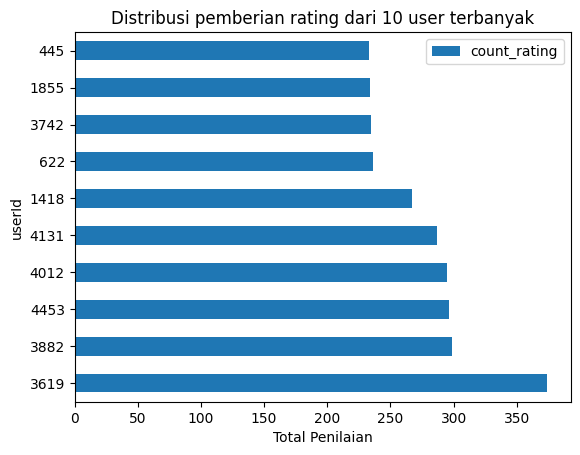

In [112]:
# menghitung tiap user telah memberikan penilaian
count = rating.userId.value_counts()
top_user = pd.DataFrame({'count_rating': count})

top_user[:10].plot(kind = 'barh')
plt.xlabel('Total Penilaian')
plt.ylabel('userId')
plt.title('Distribusi pemberian rating dari 10 user terbanyak')
plt.show()

Dari grafik diatas menunjukkan bahwa user yang memberikan rating paling banyak adalah user 3619 dengan penilaian lebih dari 350 blog

### Blog

In [113]:
# melihat data blog
blog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10467 entries, 0 to 10466
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   blog_id       10467 non-null  int64 
 1   author_id     10467 non-null  int64 
 2   blog_title    10467 non-null  object
 3   blog_content  10467 non-null  object
 4   blog_link     10467 non-null  object
 5   blog_img      10467 non-null  object
 6   topic         10467 non-null  object
 7   scrape_time   10467 non-null  object
dtypes: int64(2), object(6)
memory usage: 654.3+ KB


Pada dataset blog fitur yang digunakan hanya blog_id, author_id, blog_title, dan topic

In [114]:
# mengambil fitur yang dibutuhkan
blog = blog[['blog_id', 'author_id', 'blog_title', 'topic']]
blog.head()

,blog_id,author_id,blog_title,topic
0,1,4,Let’s Dominate The Launchpad Space Again,ai
1,3,4,Let’s Dominate The Launchpad Space Again,ai
2,4,7,Using ChatGPT for User Research,ai
3,5,8,The Automated Stable-Diffusion Checkpoint Merg...,ai
4,6,9,The Art of Lazy Creativity: My Experience Co-W...,ai


In [115]:
# melihat data unique pada blog
print('Banyak blog :', len(blog.blog_id.unique()))
print('Banyak author :', len(blog.author_id.unique()))
print('Banyak jenis konten blog :', len(blog.topic.unique()))
print('Banyak title :', len(blog.blog_title.unique()))

# mencari data duplikat
print('Jumlah data duplikat :',blog.duplicated().sum())

Banyak blog : 10467
Banyak author : 6824
Banyak jenis konten blog : 23
Banyak title : 10466
Jumlah data duplikat : 0


Dapat dilihat dari output diatas terdapat perbedaan pada jumlah blog yang ada dengan jumlah judul blog.

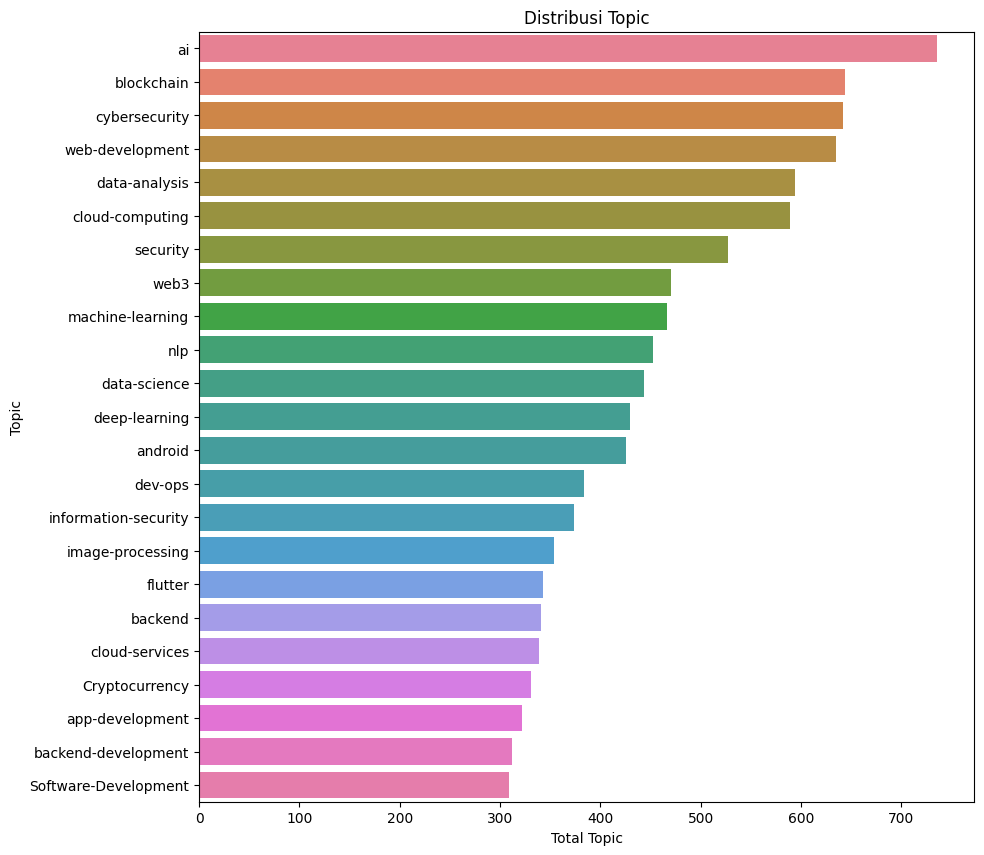

In [116]:
# ditribusi topic blog
count = blog.topic.value_counts()
jenis_topic = pd.DataFrame({'count_topic': count})

plt.figure(figsize=(10, 10))
sns.barplot(y=jenis_topic.index, x='count_topic', data=jenis_topic, hue = jenis_topic.index)
plt.xlabel('Total Topic')
plt.ylabel('Topic')
plt.title('Distribusi Topic')
plt.show()

Dari grafik distribusi menunjukkan mayoritas blog yang ada merupakan artikel blog dengan topic ai, blockchain, cybersecurity, web-development, data-analysis, dan cloud-computing.

### Author

In [117]:
# melihat data author
author.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6868 entries, 0 to 6867
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author_id    6868 non-null   int64 
 1   author_name  6868 non-null   object
dtypes: int64(1), object(1)
memory usage: 107.4+ KB


In [118]:
# melihat data unique pada author
print('Jumlah author_id :', len(author.author_id.unique()))
print('Banyak nama author :', len(author.author_name.unique()))
print('Total dupllicate data :', author.duplicated().sum())

Jumlah author_id : 6868
Banyak nama author : 6867
Total dupllicate data : 0


Dari output diatas terlihat perbedaan antara jumlah author dengan nama author

In [119]:
# mencari nama author yang memiliki lebih dari 1 author_id
author.author_name.value_counts()

Kompetify.ai                2
yaksh                       1
infoart.ca                  1
Bao Tram Duong              1
Raghavan P                  1
                           ..
Shivangsharma               1
Nithin Makam                1
Ali Samir                   1
Atul Kumar, SDE1 @ Paytm    1
Aphinya Dechalert           1
Name: author_name, Length: 6867, dtype: int64

In [120]:
# melihat author_id yang memiliki lebih dari 1 nama author
author[author.author_name == 'Kompetify.ai']

,author_id,author_name
83,84,Kompetify.ai
95,96,Kompetify.ai


Dapat dilihat pada table diatas, author dengan nama Kompetify.ai memiliki author_id 84 dan 96. Maka dari itu perlu analasis lebih lanjut, apakah jumlah author_id tersebut akan berpengaruh atau tidak

# Data Preprocessing

### Create Helper Function


In [121]:
# membuat function untuk menghilangkan tanda baca, symbol, emoji pada data
def remove_emoji_and_symbols(text):
  text_no_emoji = re.sub(r'[^\w\s\d]+', '', text)
  return text_no_emoji

### Remove punctuation, emoji, and symbol

In [122]:
# menghapus tanda baca, symbol, emoji pada title
blog['blog_title'] = blog['blog_title'].apply(lambda x: remove_emoji_and_symbols(x))

# menghapus tanda baca, symbol, emoji pada topic
blog['topic'] = blog['topic'].apply(lambda x: remove_emoji_and_symbols(x))

# menghapus tanda baca, symbol, emoji pada author_name
author['author_name'] = author['author_name'].apply(lambda x: remove_emoji_and_symbols(x))

### Merge author and blog

In [123]:
# menggabungkan dataset author dengan blog
author_new = pd.merge(author, blog, on = 'author_id', how = 'left')
author_new.shape

(10511, 5)

In [124]:
# melihat missing value pada data
author_new.isnull().sum()

author_id       0
author_name     0
blog_id        44
blog_title     44
topic          44
dtype: int64

In [125]:
# Melihat blog yang dimiliki author kompetify.ai
id1 = author_new[author_new.author_id == 84]
id2 = author_new[author_new.author_id == 96]

# menggabungkan dataframe id1 dan id2
dup_id = pd.concat([id1, id2])
dup_id

,author_id,author_name,blog_id,blog_title,topic
156,84,Kompetifyai,80.0,ChatGPTs Article on KompetifyAIs Utilities,ai
175,96,Kompetifyai,NaN,NaN,NaN


Dapat dilihat author dengan nama Kompetifyai hanya memiliki 1 buah blog pada 2 id yang berbeda, maka id yang tidak memiliki blog akan dihapus.

### Remove Missing Value

In [126]:
# melihat data nan
author_new.loc[(author_new[['blog_id', 'blog_title', 'topic']].isnull()).any(axis=1)].head()

,author_id,author_name,blog_id,blog_title,topic
0,1,yaksh,NaN,NaN,NaN
5,3,Daniel Meyer,NaN,NaN,NaN
10,5,Ifedolapo Shiloh Olotu,NaN,NaN,NaN
18,11,Crypto111,NaN,NaN,NaN
25,17,Dan H Mcinerney,NaN,NaN,NaN


In [127]:
# menghapus nilai nan
author_clean = author_new.dropna(axis = 0)
author_clean.isnull().sum()

author_id      0
author_name    0
blog_id        0
blog_title     0
topic          0
dtype: int64

In [128]:
# mengubah tipe data blog_id menjadi integer
author_clean['blog_id'] = author_clean['blog_id'].astype(int)
author_clean.shape

<ipython-input-128-fbe731b7fb83>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_clean['blog_id'] = author_clean['blog_id'].astype(int)


(10467, 5)

In [129]:
# membuat dataframe untuk melihat jumlah author id
df_author = pd.DataFrame(columns=['Jumlah'], index=['Author', 'Author Clean'])
df_author.loc['Author', 'Jumlah'] = len(author.author_id.unique())
df_author.loc['Author Clean', 'Jumlah'] = len(author_clean.author_id.unique())
df_author

,Jumlah
Author,6868
Author Clean,6824


Dari tabel diatas menunjukkan terdapat beberapa author yang tidak memiliki blog sama sekali sehingga author yang tidak memiliki blog akan dihapus.

### Create DataFrame blog_rate

In [130]:
# membuat dataframe blog rating dengan menggabungkan rating dan author_clean
blog_rate = pd.merge(rating, author_clean, on = 'blog_id', how = 'left')
blog_rate

,blog_id,userId,ratings,author_id,author_name,blog_title,topic
0,9025,11,3.5,5960,Steven Dornan,How I became a Frontend Developer,webdevelopment
1,9320,11,5.0,6155,Daniel Pericich,Writing an Algorithm to Calculate Article Read...,webdevelopment
2,9246,11,3.5,6114,Muhammad Naeem Tahir,Diving into HTML and the Tools of the Trade,webdevelopment
3,9431,11,5.0,2386,Mohit Singh,Learning Too Many Programming Languages at Once,webdevelopment
4,875,11,2.0,699,Juan In The Chain,Cryptocurrency Regulations A Tug of War Betwee...,blockchain
...,...,...,...,...,...,...,...
200135,6714,22,5.0,4623,Humberto Rendon,Challenging Assumptions Preparing for Unwanted...,dataanalysis
200136,6576,22,3.5,1438,Vishal Barvaliya,Designing a Data Model for a Library Managemen...,datascience
200137,6222,22,3.5,4346,Pol Guasch Romero,Introduction to Natural Language Processing A ...,nlp
200138,6015,22,2.0,4234,Himanshu Sharma,StanfordAlpaca ChatGPT Rival,deeplearning


<ipython-input-131-24a656cf606a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_topic = blog_rate.groupby('topic').sum().sort_values('ratings', ascending = 0)


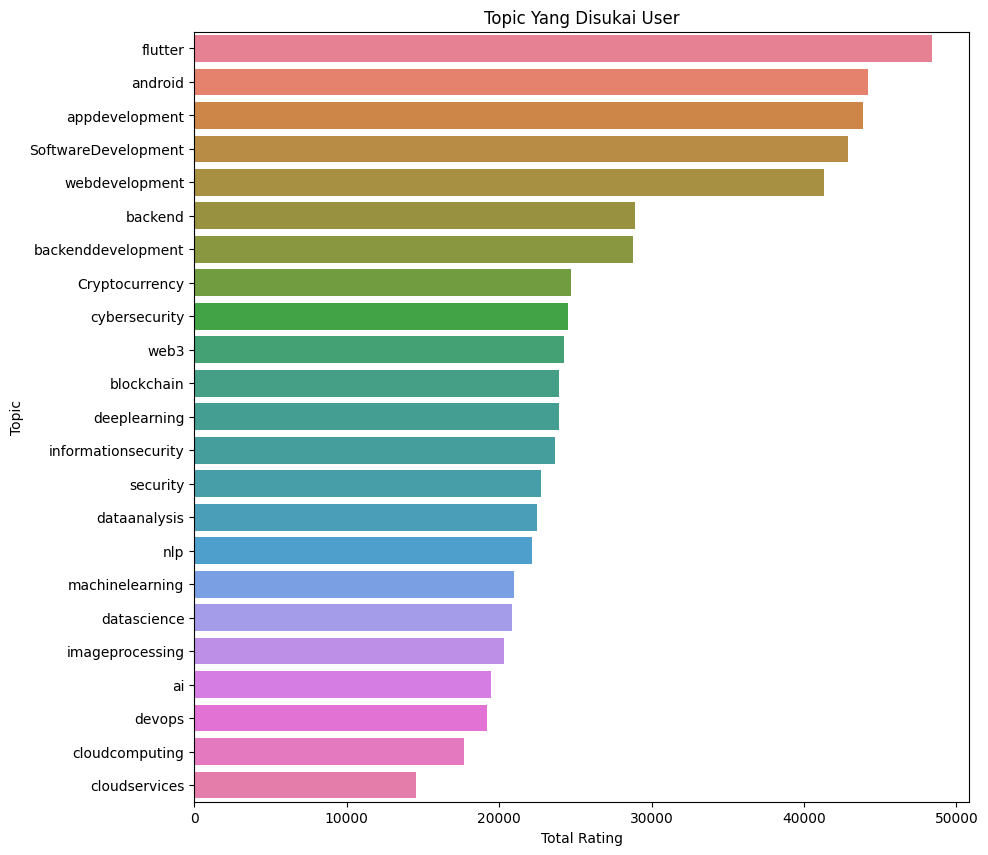

In [131]:
# melihat topic yang disukai pembaca berdasarkan rating
top_topic = blog_rate.groupby('topic').sum().sort_values('ratings', ascending = 0)

plt.figure(figsize=(10, 10))
sns.barplot(y=top_topic.index, x='ratings', data=top_topic, hue = top_topic.index)
plt.xlabel('Total Rating')
plt.ylabel('Topic')
plt.title('Topic Yang Disukai User')
plt.show()

Dari hasil distribusi user dapat disimpulkan bahwa blog dengan topic flutter, android, app-development, SoftwareDevelopment, dan web-development lebih banyak diminati oleh sebagian besar user.

# Data Preparation

In [132]:
# check missing values
blog_rate.isnull().sum()

blog_id        0
userId         0
ratings        0
author_id      0
author_name    0
blog_title     0
topic          0
dtype: int64

## Sorting Data

In [133]:
blog_rate = blog_rate.sort_values('blog_id', ascending = True)
blog_rate

,blog_id,userId,ratings,author_id,author_name,blog_title,topic
88721,1,2286,2.0,4,Seedify Fund,Lets Dominate The Launchpad Space Again,ai
81293,1,2103,5.0,4,Seedify Fund,Lets Dominate The Launchpad Space Again,ai
105291,1,2686,3.5,4,Seedify Fund,Lets Dominate The Launchpad Space Again,ai
47766,1,1256,0.5,4,Seedify Fund,Lets Dominate The Launchpad Space Again,ai
113463,1,2927,5.0,4,Seedify Fund,Lets Dominate The Launchpad Space Again,ai
...,...,...,...,...,...,...,...
76063,9755,1985,5.0,6408,Sabyna Maharani,Embracing the Magic of Scrum,SoftwareDevelopment
135155,9755,3464,5.0,6408,Sabyna Maharani,Embracing the Magic of Scrum,SoftwareDevelopment
106639,9755,2724,2.0,6408,Sabyna Maharani,Embracing the Magic of Scrum,SoftwareDevelopment
108761,9755,2787,5.0,6408,Sabyna Maharani,Embracing the Magic of Scrum,SoftwareDevelopment


In [134]:
print('Jumlah Blog unique :',len(blog_rate.blog_id.unique()))
print('Jumlah Title unique :',len(blog_rate.blog_title.unique()))

Jumlah Blog unique : 9706
Jumlah Title unique : 9696


Terdapat perbedaan anatra jumlah blog yang ada dengan judul blog, dimana seharusnya tiap blog memiliki id dan judulnya masing-masing (unique)

## Remove Duplicate Data

In [135]:
# membuat dataframe preparation yang berisi blog_rate dan membuang duplicate value
preparation = blog_rate.drop_duplicates('blog_title')
preparation

,blog_id,userId,ratings,author_id,author_name,blog_title,topic
88721,1,2286,2.0,4,Seedify Fund,Lets Dominate The Launchpad Space Again,ai
101509,4,2600,5.0,7,Nick Babich,Using ChatGPT for User Research,ai
158476,5,4002,2.0,8,Xerxemi,The Automated StableDiffusion Checkpoint Merge...,ai
101542,6,2600,2.0,9,Harry Alexander,The Art of Lazy Creativity My Experience CoWri...,ai
157215,7,3970,5.0,10,E2Analyst,LLaMA Everything you want to know about Metas ...,ai
...,...,...,...,...,...,...,...
160925,9751,4054,0.5,6406,Suraj Mishra,HashMap Initialization tricks in Java,SoftwareDevelopment
103402,9752,2645,3.5,5658,Keren Kenzi,Express Yourself Clearly And Cleanly,SoftwareDevelopment
40253,9753,1042,2.0,6407,WillemJan Ageling,SAFe has an update I look into the changes so...,SoftwareDevelopment
133266,9754,3420,5.0,6343,Tom Smykowski,NumPy 1240 Release Improved Data Handling Exe...,SoftwareDevelopment


## Selection Feature & Convert Data to List

In [136]:
# Mengonversi data series ‘blog_id’ menjadi dalam bentuk list
blog_id = preparation['blog_id'].tolist()

# Mengonversi data series ‘Name’ menjadi dalam bentuk list
blog_title = preparation['blog_title'].tolist()

# Mengonversi data series ‘Rcuisine’ menjadi dalam bentuk list
topic = preparation['topic'].tolist()

print(len(blog_id))
print(len(blog_title))
print(len(topic))

9696
9696
9696


In [137]:
# membuat dataframe final_preparation dan diisi dengan blog_id, blog_title, topic
final_preparation = pd.DataFrame({'blog_id': blog_id,
                                  'title': blog_title,
                                  'topic': topic})

final_preparation

,blog_id,title,topic
0,1,Lets Dominate The Launchpad Space Again,ai
1,4,Using ChatGPT for User Research,ai
2,5,The Automated StableDiffusion Checkpoint Merge...,ai
3,6,The Art of Lazy Creativity My Experience CoWri...,ai
4,7,LLaMA Everything you want to know about Metas ...,ai
...,...,...,...
9691,9751,HashMap Initialization tricks in Java,SoftwareDevelopment
9692,9752,Express Yourself Clearly And Cleanly,SoftwareDevelopment
9693,9753,SAFe has an update I look into the changes so...,SoftwareDevelopment
9694,9754,NumPy 1240 Release Improved Data Handling Exe...,SoftwareDevelopment


# Model Development

- Content Based Filtering
- Collaborative Filtering

## Content Based Filtering

In [138]:
data = final_preparation
data.head()

,blog_id,title,topic
0,1,Lets Dominate The Launchpad Space Again,ai
1,4,Using ChatGPT for User Research,ai
2,5,The Automated StableDiffusion Checkpoint Merge...,ai
3,6,The Art of Lazy Creativity My Experience CoWri...,ai
4,7,LLaMA Everything you want to know about Metas ...,ai


### TF-IDF

In [139]:
tfidf = TfidfVectorizer()

# menghitung idf pada data topic
tfidf.fit(data['topic'])

# Mapping array dari fitur index integer ke fitur nama
tfidf.get_feature_names_out()

array(['ai', 'android', 'appdevelopment', 'backend', 'backenddevelopment',
       'blockchain', 'cloudcomputing', 'cloudservices', 'cryptocurrency',
       'cybersecurity', 'dataanalysis', 'datascience', 'deeplearning',
       'devops', 'flutter', 'imageprocessing', 'informationsecurity',
       'machinelearning', 'nlp', 'security', 'softwaredevelopment',
       'web3', 'webdevelopment'], dtype=object)

In [140]:
# melakukan fit lalu tranformasiakan ke bentuk matrix
tfidf_matrix = tfidf.fit_transform(data['topic'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(9696, 23)

In [141]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]])

In [142]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan topic
# Baris diisi dengan title

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=data.title
).sample(23, axis=1).sample(5, axis=0)

,nlp,cryptocurrency,dataanalysis,ai,datascience,cloudservices,backend,cloudcomputing,backenddevelopment,devops,...,android,security,informationsecurity,blockchain,softwaredevelopment,cybersecurity,imageprocessing,flutter,deeplearning,webdevelopment
title,,,,,,,,,,,,,,,,,,,,,
When to Use Logistic Regression vs Deep Learning for Business Problems,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hello Pets Updates 2023 Q1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sht we found interesting this week Volume 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Web3Web2 Security Closer than you think,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NodeJs ile Excel Dosyası Oluşturma ve Express ile Sunma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cosine Similarity

In [143]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [144]:
cos_sim_df = pd.DataFrame(cos_sim, index = data['title'], columns = data['title'])

# melihat similarity matrix pada setiap resto
cos_sim_df.sample(5, axis= 1).sample(5, axis = 0)

title,Building Your Developer Portal with Backstage a Comprehensive Tutorial,Is Offline reinforcement learning the future part2Machine Learning,CUDOS POWERING THE METAVERSE,Mobile Movement Dialect Rugged By Apple Solana Mobile Creates History Again METAVERTU Builds Luxury Web3 Phone,Socket Programming in Go Write a simple TCP clientserver
title,,,,,
Why Web3 is the Next Big Thing,0.0,0.0,0.0,1.0,0.0
Toolkits to make AI based simulations of cityscapes with Unreal Engine,0.0,0.0,0.0,0.0,0.0
Device Recognition vs User Authentication Whats the Difference,0.0,0.0,0.0,0.0,0.0
Titanic Survival Analysis,0.0,0.0,0.0,0.0,0.0
SkyLine An Informative Document,0.0,0.0,0.0,0.0,0.0


### Recommendation Function

In [145]:
def blog_recommendation(title_blog, similarity_data = cos_sim_df, items = data[['title', 'topic']], k = 10):
  # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
  # Dataframe diubah menjadi numpy
  # Range(start, stop, step)

  index = similarity_data.loc[:,title_blog].to_numpy().argpartition(range(-1, -k, -1))

  # Mengambil data dengan similarity terbesar dari index yang ada
  closest = similarity_data.columns[index[-1:-(k+2):-1]]

  # Drop title_blog agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
  closest = closest.drop(title_blog, errors='ignore')

  return pd.DataFrame(closest).merge(items).head(k)

### Evaluasi Model Content Based Filtering

In [146]:
data[data.title == 'sqlite from a web page']

,blog_id,title,topic
9088,9145,sqlite from a web page,webdevelopment


In [147]:
# mencoba mendapatkan rekomendai blog
blog_recommendation('sqlite from a web page')

,title,topic
0,The Pros and Cons of Using OpenSource Software...,webdevelopment
1,Solution 5 Agnostics From hodling to thrivin...,webdevelopment
2,Mastering Reducers A Comprehensive Guide for E...,webdevelopment
3,Why I Wouldnt Hire Cool Programmers if I Launc...,webdevelopment
4,React Application Gets Depressed and Finds The...,webdevelopment
5,10 RxJS operators which I use daily as an Angu...,webdevelopment
6,Stop Using Docker,webdevelopment
7,Basics of Working with APIs,webdevelopment
8,Redux Simplified A Beginners Guide to the Core...,webdevelopment
9,How im going to build OXINION Finance with Cha...,webdevelopment


## Collaborative Filtering

In [148]:
df = blog_rate
df

,blog_id,userId,ratings,author_id,author_name,blog_title,topic
88721,1,2286,2.0,4,Seedify Fund,Lets Dominate The Launchpad Space Again,ai
81293,1,2103,5.0,4,Seedify Fund,Lets Dominate The Launchpad Space Again,ai
105291,1,2686,3.5,4,Seedify Fund,Lets Dominate The Launchpad Space Again,ai
47766,1,1256,0.5,4,Seedify Fund,Lets Dominate The Launchpad Space Again,ai
113463,1,2927,5.0,4,Seedify Fund,Lets Dominate The Launchpad Space Again,ai
...,...,...,...,...,...,...,...
76063,9755,1985,5.0,6408,Sabyna Maharani,Embracing the Magic of Scrum,SoftwareDevelopment
135155,9755,3464,5.0,6408,Sabyna Maharani,Embracing the Magic of Scrum,SoftwareDevelopment
106639,9755,2724,2.0,6408,Sabyna Maharani,Embracing the Magic of Scrum,SoftwareDevelopment
108761,9755,2787,5.0,6408,Sabyna Maharani,Embracing the Magic of Scrum,SoftwareDevelopment


### Membuat List Profile User

In [149]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df['userId'].unique().tolist()
print('list userId: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userId:  [2286, 2103, 2686, 1256, 2927, 4544, 4052, 624, 2095, 4904, 3933, 2172, 1194, 3845, 3895, 2157, 2465, 4830, 2600, 4244, 148, 2299, 2001, 4896, 4002, 4267, 44, 2229, 11, 1486, 560, 2744, 1569, 754, 1747, 14, 1592, 2648, 4871, 1232, 2743, 3970, 883, 1567, 4372, 4907, 2898, 4613, 3158, 4415, 1245, 566, 1765, 955, 3060, 1857, 359, 2427, 1099, 2994, 1891, 268, 2852, 4635, 931, 919, 4960, 4311, 381, 881, 269, 2510, 819, 2522, 316, 3409, 4228, 4815, 4196, 628, 3754, 4938, 2857, 4219, 1557, 1880, 1000, 1894, 2596, 4319, 4227, 2126, 3927, 358, 4795, 3238, 3996, 3993, 1647, 4788, 3140, 1914, 4272, 4439, 2656, 3322, 4191, 1002, 3195, 1276, 519, 3701, 4282, 1019, 4797, 3164, 452, 1889, 595, 331, 3252, 763, 1303, 1356, 3008, 2308, 29, 4225, 4637, 4631, 1573, 792, 4049, 115, 845, 1225, 2520, 4558, 3449, 3400, 1848, 3679, 3781, 4977, 3176, 1699, 2138, 2362, 4858, 3293, 1290, 85, 493, 498, 1955, 3742, 3277, 2487, 3578, 3018, 546, 3876, 4412, 2424, 1165, 1901, 249, 4140, 88, 3553, 1278, 1

In [150]:
# Mengubah blog_id menjadi list tanpa nilai yang sama
blog_ids = df['blog_id'].unique().tolist()

# Melakukan proses encoding blog_id
blog_to_blog_encoded = {x: i for i, x in enumerate(blog_ids)}

# Melakukan proses encoding angka ke blog_id
blog_encoded_to_blog = {i: x for i, x in enumerate(blog_ids)}

In [151]:
# Mapping userId ke dataframe user
df['user'] = df['userId'].map(user_to_user_encoded)

# Mapping blog_id ke dataframe blog
df['blog'] = df['blog_id'].map(blog_to_blog_encoded)

In [152]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah blog
num_blog = len(blog_encoded_to_blog)
print(num_blog)

# Nilai minimum rating
min_rating = min(df['ratings'])

# Nilai maksimal rating
max_rating = max(df['ratings'])

print('Number of User: {}, Number of blog: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_blog, min_rating, max_rating
))

5001
9706
Number of User: 5001, Number of blog: 9706, Min Rating: 0.5, Max Rating: 5.0


In [153]:
df = df.sample(frac = 1, random_state = 42)
df

,blog_id,userId,ratings,author_id,author_name,blog_title,topic,user,blog
80178,7748,2078,5.0,1960,Dileep Kumar,Streamlining Mobile App Development with Appci...,devops,3769,7703
28711,4061,730,2.0,500,Anthony Today,Online Income Generation Balancing Opportuniti...,informationsecurity,2105,4025
31651,8723,813,5.0,5561,Muhammadumarch,Testing and Debugging in Flutter,flutter,234,8676
75730,9119,1976,3.5,6034,Akhil,Callback function in JavaScript,webdevelopment,4887,9071
183881,9074,4637,2.0,2969,Dino Cajic,Advantages of using Docker for Development,webdevelopment,128,9026
...,...,...,...,...,...,...,...,...,...
8340,7190,207,2.0,4937,Nihal Dias,Modernizing Your Web App with React Advantages...,cloudcomputing,3088,7146
157686,6173,3979,5.0,4314,Ben Burtenshaw,Using Transformer Reinforcement Learning to De...,nlp,3186,6132
50749,8003,1336,5.0,5381,Ian Williams,Vivaldi for Chrome OS Review,android,664,7958
91109,8433,2336,5.0,5664,Philip Martin,Help App Users See Value Quickly,appdevelopment,4026,8387


#### Split Data

In [154]:
# membuat variabel x untuk mencocokkan data user dan blog
x = df[['user', 'blog']].values

# membuat variabel y untuk hasil ratings
y = df['ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

sample = int(0.8 * df.shape[0])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = sample, random_state = None)
print(x,y)

[[3769 7703]
 [2105 4025]
 [ 234 8676]
 ...
 [ 664 7958]
 [4026 8387]
 [ 926 7365]] [1.         0.33333333 1.         ... 1.         1.         1.        ]


### Class ReccomenderNet

In [155]:
class RecommenderNet(tf.keras.Model):
  # Insialisasi fungsi
  def __init__(self, num_users, num_blog, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_blog = num_blog
    self.embedding_size = embedding_size
    self.user_embedding = tf.keras.layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.user_bias = tf.keras.layers.Embedding(num_users, 1) # layer embedding user bias
    self.blog_embedding = tf.keras.layers.Embedding( # layer embeddings blog
        num_blog,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.blog_bias = tf.keras.layers.Embedding(num_blog, 1) # layer embedding blog bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    blog_vector = self.blog_embedding(inputs[:, 1]) # memanggil layer embedding 3
    blog_bias = self.blog_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_blog = tf.tensordot(user_vector, blog_vector, 2)

    x = dot_user_blog + user_bias + blog_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [156]:
# compile model
model = RecommenderNet(num_users, num_blog, 64) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# callbacks
callbacks = tf.keras.callbacks.EarlyStopping(
    min_delta=0.0001,
    monitor = 'val_loss',
    patience=5,
    restore_best_weights=True,
)

### Training

In [157]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 50,
    callbacks = [callbacks],
    validation_data = (x_val, y_val)
)

Epoch 1/50
5004/5004 [==============================] - 121s 24ms/step - loss: 0.6934 - root_mean_squared_error: 0.4013 - val_loss: 0.6930 - val_root_mean_squared_error: 0.4012
Epoch 2/50
5004/5004 [==============================] - 104s 21ms/step - loss: 0.6905 - root_mean_squared_error: 0.3995 - val_loss: 0.6926 - val_root_mean_squared_error: 0.4009
Epoch 3/50
5004/5004 [==============================] - 105s 21ms/step - loss: 0.6874 - root_mean_squared_error: 0.3975 - val_loss: 0.6922 - val_root_mean_squared_error: 0.4007
Epoch 4/50
5004/5004 [==============================] - 100s 20ms/step - loss: 0.6841 - root_mean_squared_error: 0.3954 - val_loss: 0.6919 - val_root_mean_squared_error: 0.4004
Epoch 5/50
5004/5004 [==============================] - 103s 21ms/step - loss: 0.6805 - root_mean_squared_error: 0.3931 - val_loss: 0.6915 - val_root_mean_squared_error: 0.4001
Epoch 6/50
5004/5004 [==============================] - 102s 20ms/step - loss: 0.6769 - root_mean_squared_error: 0.

### Evaluasi Model Collaborative Filtering

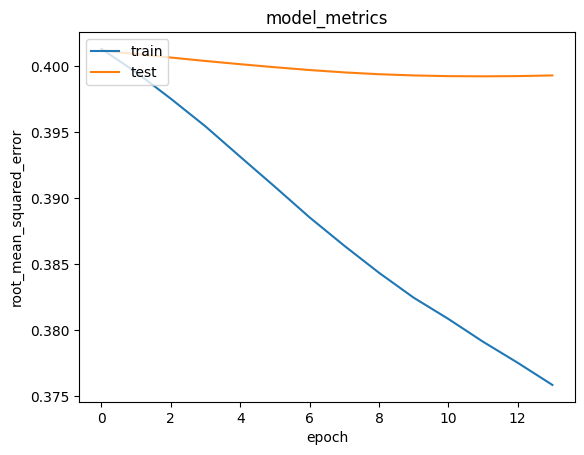

In [158]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Dari hasil visualisasi training diatas didapatkan nilai error akhir sebesar 0.375 dan nilai error sebesar 0.39 pada validasi. Nilai tersebut sudah cukup baik untuk sistem rekomendasi.

### Test Prediction

In [159]:
blog_df = final_preparation
df = rating

# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
blog_read_by_user = df[df.userId == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
blog_not_read = blog_df[~blog_df['blog_id'].isin(blog_read_by_user.blog_id.values)]['blog_id']
blog_not_read = list(
  set(blog_not_read)
  .intersection(set(blog_to_blog_encoded.keys()))
)

blog_not_read = [[blog_to_blog_encoded.get(x)] for x in blog_not_read]
user_encoder = user_to_user_encoded.get(user_id)
user_blog_array = np.hstack(
  ([[user_encoder]] * len(blog_not_read), blog_not_read)
)

In [160]:
recom_blog = model.predict(user_blog_array).flatten()

top_ratings_indices = recom_blog.argsort()[-10:][::-1]
recommended_blog_ids = [
    blog_to_blog_encoded.get(blog_not_read[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Blog with high ratings from user')
print('----' * 8)

top_blog_user = (
    blog_read_by_user.sort_values(
        by = 'ratings',
        ascending=False
    )
    .head(5)
    .blog_id.values
)

blog_df_rows = blog_df[blog_df['blog_id'].isin(top_blog_user)]
for row in blog_df_rows.itertuples():
    print(row.title, ':', row.topic)

print('----' * 8)
print('Top 10 Blog recommendation')
print('----' * 8)

recommended_blog = blog_df[blog_df['blog_id'].isin(recommended_blog_ids)]
for row in recommended_blog.itertuples():
    print(row.title, ':', row.topic)

300/300 [==============================] - 0s 1ms/step
Showing recommendations for users: 3036
Blog with high ratings from user
--------------------------------
Revolutionizing Business Communications with LLaMA The New AI Language Model : machinelearning
Unleashing the Power of Go Concurrency and Python to Tame Bangalore Traffic Flowing More Freely Than Silk Board : SoftwareDevelopment
xkite makes it easy to prototype test and deploy Apache Kafka : SoftwareDevelopment
Week in Review March 18 2023 : SoftwareDevelopment
5 CommandLine API Tools You Need To Try : SoftwareDevelopment
--------------------------------
Top 10 Blog recommendation
--------------------------------
 The Software Developer Strikes : SoftwareDevelopment
Are test fixtures worth it in your automated testing strategy : SoftwareDevelopment
Writing Better Commits : SoftwareDevelopment
 Typescript Devs Suffer For 5 Years Because Of This : SoftwareDevelopment
Why 2023 is an interesting year for Software Engineering : Soft